# 对预测图片的水平过滤

In [10]:
import os
import cv2
import numpy as np
if __name__ == "__main__":
    predict_path="predict_img"
    filename = os.listdir(predict_path)
    base_dir = predict_path + "\\"
    out_path = "predict_outimg/"  #以\\结尾
    kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    for img in filename:     
        im = cv2.imread(base_dir + img)
        new_img = cv2.filter2D(im,-1,kernel)
        cv2.imwrite(out_path + img, new_img)

# 预测

In [11]:
# %load predict.py
#----------------------------------------------------#
#   将单张图片预测、摄像头检测和FPS测试功能
#   整合到了一个py文件中，通过指定mode进行模式的修改。
#----------------------------------------------------#
import time

import cv2
import numpy as np
from PIL import Image

from unet import Unet

if __name__ == "__main__":
    #-------------------------------------------------------------------------#
    #   如果想要修改对应种类的颜色，到__init__函数里修改self.colors即可
    #-------------------------------------------------------------------------#
    unet = Unet()
    #----------------------------------------------------------------------------------------------------------#
    #   mode用于指定测试的模式：
    #   'predict'           表示单张图片预测，如果想对预测过程进行修改，如保存图片，截取对象等，可以先看下方详细的注释
    #   'dir_predict'       表示遍历文件夹进行检测并保存。默认遍历img文件夹，保存img_out文件夹，详情查看下方注释。
    #----------------------------------------------------------------------------------------------------------#
    mode = "dir_predict"
    #-------------------------------------------------------------------------#
    #   count               指定了是否进行目标的像素点计数（即面积）与比例计算
    #   name_classes        区分的种类，和json_to_dataset里面的一样，用于打印种类和数量
    #
    #   count、name_classes仅在mode='predict'时有效
    #-------------------------------------------------------------------------#
    count           = False
    name_classes    = ["background","line"]
    #----------------------------------------------------------------------------------------------------------#
    #   video_path          用于指定视频的路径，当video_path=0时表示检测摄像头
    #                       想要检测视频，则设置如video_path = "xxx.mp4"即可，代表读取出根目录下的xxx.mp4文件。
    #   video_save_path     表示视频保存的路径，当video_save_path=""时表示不保存
    #                       想要保存视频，则设置如video_save_path = "yyy.mp4"即可，代表保存为根目录下的yyy.mp4文件。
    #   video_fps           用于保存的视频的fps
    #
    #   video_path、video_save_path和video_fps仅在mode='video'时有效
    #   保存视频时需要ctrl+c退出或者运行到最后一帧才会完成完整的保存步骤。
    #----------------------------------------------------------------------------------------------------------#
    video_path      = 0
    video_save_path = ""
    video_fps       = 25.0
    #----------------------------------------------------------------------------------------------------------#
    #   test_interval       用于指定测量fps的时候，图片检测的次数。理论上test_interval越大，fps越准确。
    #   fps_image_path      用于指定测试的fps图片
    #   
    #   test_interval和fps_image_path仅在mode='fps'有效
    #----------------------------------------------------------------------------------------------------------#
    test_interval = 100
    fps_image_path  = "predict_outimg/line.jpg"
    #-------------------------------------------------------------------------#
    #   dir_origin_path     指定了用于检测的图片的文件夹路径
    #   dir_save_path       指定了检测完图片的保存路径
    #   
    #   dir_origin_path和dir_save_path仅在mode='dir_predict'时有效
    #-------------------------------------------------------------------------#
    dir_origin_path = "predict_outimg/"
    dir_save_path   = "img_out/"

    if mode == "predict":
        '''
        predict.py有几个注意点
        1、该代码无法直接进行批量预测，如果想要批量预测，可以利用os.listdir()遍历文件夹，利用Image.open打开图片文件进行预测。
        具体流程可以参考get_miou_prediction.py，在get_miou_prediction.py即实现了遍历。
        2、如果想要保存，利用r_image.save("img.jpg")即可保存。
        3、如果想要原图和分割图不混合，可以把blend参数设置成False。
        4、如果想根据mask获取对应的区域，可以参考detect_image函数中，利用预测结果绘图的部分，判断每一个像素点的种类，然后根据种类获取对应的部分。
        seg_img = np.zeros((np.shape(pr)[0],np.shape(pr)[1],3))
        for c in range(self.num_classes):
            seg_img[:, :, 0] += ((pr == c)*( self.colors[c][0] )).astype('uint8')
            seg_img[:, :, 1] += ((pr == c)*( self.colors[c][1] )).astype('uint8')
            seg_img[:, :, 2] += ((pr == c)*( self.colors[c][2] )).astype('uint8')
        '''
        while True:
            img = input('Input image filename:')
            if img == "q":
                break
            else:
                try:
                    image = Image.open(img)
                except:
                    print('Open Error! Try again!')
                    continue
                else:
                    r_image = unet.detect_image(image, count=count, name_classes=name_classes)
                    r_image.show()

    elif mode == "dir_predict":
        import os
        from tqdm import tqdm

        img_names = os.listdir(dir_origin_path)
        for img_name in tqdm(img_names):
            if img_name.lower().endswith(('.bmp', '.dib', '.png', '.jpg', '.jpeg', '.pbm', '.pgm', '.ppm', '.tif', '.tiff')):
                image_path  = os.path.join(dir_origin_path, img_name)
                image       = Image.open(image_path)
                r_image     = unet.detect_image(image)
                if not os.path.exists(dir_save_path):
                    os.makedirs(dir_save_path)
                r_image.save(os.path.join(dir_save_path, img_name))
                
    else:
        raise AssertionError("Please specify the correct mode: 'predict', 'video', 'fps' or 'dir_predict'.")


logs/best_epoch_weights.h5 model loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path |               logs/best_epoch_weights.h5|
|              num_classes |                                        2|
|                 backbone |                                      vgg|
|              input_shape |                               [512, 512]|
|                 mix_type |                                        1|
----------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.13it/s]


# 去除噪声

In [12]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil
from skimage import morphology
if __name__ == "__main__":
    predict_path = "img_out"
    filename = os.listdir(predict_path)
    base_dir = predict_path + "\\"
    binaryzation_dir = "binaryzation_img/"
    label_dir = "label_img/"
    for img in filename:     
        # 读入图片
        im = cv2.imread(base_dir + img)
        # 中值滤波，去噪
        im = cv2.medianBlur(im, 3)
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        # 阈值分割得到二值化图片
        ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        #将二值化图像使用布尔型标记
        binary_x,binary_y=binary.shape
        for i in range(binary_x):
            for j in range(binary_y):
                if binary[i][j]==255:
                    binary[i][j]=1
        binary_img=binary.astype(np.bool_)
        #去除面积小于1000的连通区域
        image=morphology.remove_small_objects(binary_img, 1000)
        #将存放布尔型的数组转为二值化图像的数组
        image_remove_small = np.zeros((binary_x, binary_y), dtype=np.uint8)
        for i in range(binary_x):
            for j in range(binary_y):
                if image[i][j]==False:
                    image_remove_small[i][j]=0
                else:
                    image_remove_small[i][j]=255
        cv2.imwrite(binaryzation_dir + img, image_remove_small)
        # 膨胀操作
        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        bin_clo = cv2.dilate(image_remove_small, kernel2, iterations=2)
        
        print('****************************** 时频图'+img+'预测信息如下： ******************************')
        # 连通域分析
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_clo, connectivity=8)

        # 查看各个返回值
        # 连通域数量
#         print('num_labels = ',num_labels)
        # 连通域的信息：对应各个轮廓的x、y、width、height和面积
#         print('stats = ',stats)
        # 连通域的中心点
#         print('centroids = ',centroids)
        # 每一个像素的标签1、2、3.。。，同一个连通域的标签是一致的
#         print('labels = ',labels)

        # 不同的连通域赋予不同的颜色
        output = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
        for i in range(1,num_labels):

            mask = labels == i
            output[:, :, 0][mask] = np.random.randint(0, 255)
            output[:, :, 1][mask] = np.random.randint(0, 255)
            output[:, :, 2][mask] = np.random.randint(0, 255)
        cv2.imwrite(label_dir + img, output)
        
        for i in range(1,num_labels):
            heigh = 517 - centroids[i][1]
#             hz = 2.5*10**4*heigh/binary_y
#             print('第'+str(i)+'条直线的中心位于的频率为：'+str(hz)+'Hz')
            
            hz = round(2.5*heigh/517,1)
            print('第'+str(i)+'条直线的中心位于的频率为：'+str(hz)+'×10^4 Hz')
#             print('第'+str(i)+'条直线的起始像素点的坐标为：（'+str(stats[i][0])+','+str(stats[i][1])+'）。')
        print('*****************************************************************************************')
        


****************************** 时频图137.jpg预测信息如下： ******************************
第1条直线的中心位于的频率为：2.4×10^4 Hz
第2条直线的中心位于的频率为：2.2×10^4 Hz
第3条直线的中心位于的频率为：2.0×10^4 Hz
*****************************************************************************************
****************************** 时频图138.jpg预测信息如下： ******************************
第1条直线的中心位于的频率为：2.4×10^4 Hz
第2条直线的中心位于的频率为：2.2×10^4 Hz
第3条直线的中心位于的频率为：2.0×10^4 Hz
*****************************************************************************************
****************************** 时频图141.jpg预测信息如下： ******************************
第1条直线的中心位于的频率为：2.4×10^4 Hz
第2条直线的中心位于的频率为：2.2×10^4 Hz
第3条直线的中心位于的频率为：2.0×10^4 Hz
*****************************************************************************************
****************************** 时频图142.jpg预测信息如下： ******************************
第1条直线的中心位于的频率为：2.4×10^4 Hz
第2条直线的中心位于的频率为：2.2×10^4 Hz
第3条直线的中心位于的频率为：2.0×10^4 Hz
**************************************************************************************

# 模型评估

Load model.
logs/best_epoch_weights.h5 model loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path |               logs/best_epoch_weights.h5|
|              num_classes |                                        2|
|                 backbone |                                      vgg|
|              input_shape |                               [512, 512]|
|                 mix_type |                                        1|
----------------------------------------------------------------------
Load model done.
Get predict result.


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.80it/s]


Get predict result done.
Get miou.
Num classes 2
10 / 21: mIou-87.17%; mPA-93.33%; Accuracy-98.25%
20 / 21: mIou-88.69%; mPA-93.64%; Accuracy-98.44%
===>_background_:	Iou-98.34; Recall (equal to the PA)-99.18; Precision-99.15
===>line:	Iou-79.05; Recall (equal to the PA)-88.1; Precision-88.49
===> mIoU: 88.69; mPA: 93.64; Accuracy: 98.44
Get miou done.


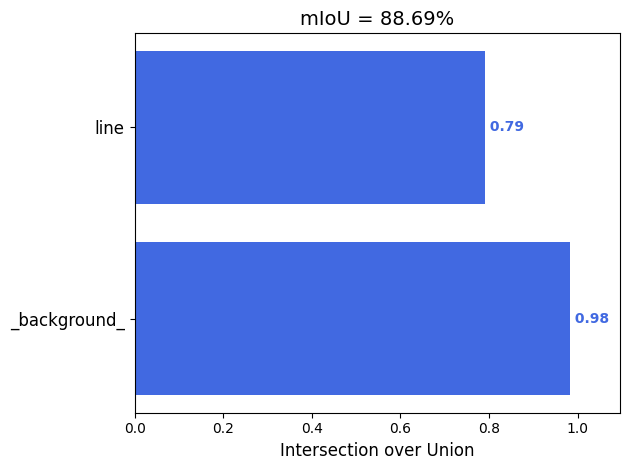

Save mIoU out to miou_out\mIoU.png
Save mPA out to miou_out\mPA.png
Save Recall out to miou_out\Recall.png
Save Precision out to miou_out\Precision.png
Save confusion_matrix out to miou_out\confusion_matrix.csv


In [4]:
# %load get_miou.py
import os

from PIL import Image
from tqdm import tqdm

from unet import Unet
from utils.utils_metrics import compute_mIoU, show_results

'''
进行指标评估需要注意以下几点：
1、该文件生成的图为灰度图，因为值比较小，按照JPG形式的图看是没有显示效果的，所以看到近似全黑的图是正常的。
2、该文件计算的是验证集的miou，当前该库将测试集当作验证集使用，不单独划分测试集
3、仅有按照VOC格式数据训练的模型可以利用这个文件进行miou的计算。
'''
if __name__ == "__main__":
    #---------------------------------------------------------------------------#
    #   miou_mode用于指定该文件运行时计算的内容
    #   miou_mode为0代表整个miou计算流程，包括获得预测结果、计算miou。
    #   miou_mode为1代表仅仅获得预测结果。
    #   miou_mode为2代表仅仅计算miou。
    #---------------------------------------------------------------------------#
    miou_mode       = 0
    #------------------------------#
    #   分类个数+1、如2+1
    #------------------------------#
    num_classes     = 2
    #--------------------------------------------#
    #   区分的种类，和json_to_dataset里面的一样
    #--------------------------------------------#
    name_classes    = ["_background_","line"]
    # name_classes    = ["_background_","cat","dog"]
    #-------------------------------------------------------#
    #   指向VOC数据集所在的文件夹
    #   默认指向根目录下的VOC数据集
    #-------------------------------------------------------#
    VOCdevkit_path  = 'VOCdevkit'

    image_ids       = open(os.path.join(VOCdevkit_path, "VOC2007/ImageSets/Segmentation/val.txt"),'r').read().splitlines() 
    gt_dir          = os.path.join(VOCdevkit_path, "VOC2007/SegmentationClass/")
    miou_out_path   = "miou_out"
    pred_dir        = os.path.join(miou_out_path, 'detection-results')

    if miou_mode == 0 or miou_mode == 1:
        if not os.path.exists(pred_dir):
            os.makedirs(pred_dir)
            
        print("Load model.")
        unet = Unet()
        print("Load model done.")

        print("Get predict result.")
        for image_id in tqdm(image_ids):
            image_path  = os.path.join(VOCdevkit_path, "VOC2007/JPEGImages/"+image_id+".jpg")
            image       = Image.open(image_path)
            image       = unet.get_miou_png(image)
            image.save(os.path.join(pred_dir, image_id + ".png"))
        print("Get predict result done.")

    if miou_mode == 0 or miou_mode == 2:
        print("Get miou.")
        hist, IoUs, PA_Recall, Precision = compute_mIoU(gt_dir, pred_dir, image_ids, num_classes, name_classes)  # 执行计算mIoU的函数
        print("Get miou done.")
        show_results(miou_out_path, hist, IoUs, PA_Recall, Precision, name_classes)